# Low-Rank GW

We provide in this tutorial a minimal example that shows the low-rank (LR) Gromov-Wasserstein solver in action. This quadratic OT solver is presented in {cite}`scetbon:22`, as a follow up to the (linear) LR Sinkhorn solver in {cite}`scetbon:21`, see {doc}`LRSinkhorn`.

In [1]:
import sys

if "google.colab" in sys.modules:
    !pip install -q git+https://github.com/ott-jax/ott@main

In [2]:
import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt

from ott.geometry import pointcloud
from ott.problems.quadratic import quadratic_problem
from ott.solvers.quadratic import gromov_wasserstein, gromov_wasserstein_lr

Helper function to instantiate three point clouds in different dimensions

In [3]:
def create_points(
    rng: jax.random.PRNGKeyArray, n: int, m: int, d1: int, d2: int
):
    rngs = jax.random.split(rng, 5)
    x = jax.random.uniform(rngs[0], (n, d1))
    y = jax.random.uniform(rngs[1], (m, d2))
    a = jax.random.uniform(rngs[2], (n,))
    b = jax.random.uniform(rngs[3], (m,))
    a = a / jnp.sum(a)
    b = b / jnp.sum(b)
    z = jax.random.uniform(rngs[4], (m, d1))
    return x, y, a, b, z


rng = jax.random.PRNGKey(0)
n, m, d1, d2 = 24, 17, 2, 3
x, y, a, b, z = create_points(rng, n, m, d1, d2)

After creating two point clouds in 2-d and 3-d,  add a third arbitrary geometry to formulate a fused problem {cite}`vayer:20`.

In [4]:
geom_xx = pointcloud.PointCloud(x)
geom_yy = pointcloud.PointCloud(y)
geom_xy = pointcloud.PointCloud(x, z)
prob = quadratic_problem.QuadraticProblem(
    geom_xx,
    geom_yy,
    geom_xy=geom_xy,
    a=a,
    b=b,
    fused_penalty=1.0,
)

Solve the problem using the {class}`~ott.solvers.quadratic.gromov_wasserstein_lr.LRGromovWasserstein` solver.

In [5]:
solver = gromov_wasserstein_lr.LRGromovWasserstein(rank=6)
ot_gwlr = solver(prob)

Furthermore, we also run the entropic {class}`~ott.solvers.quadratic.gromov_wasserstein.GromovWasserstein` solver for the sake of comparison.

In [6]:
solver = gromov_wasserstein.GromovWasserstein(epsilon=0.05)
ot_gw = solver(prob)

One can notice that their outputs are quantitatively similar with respect to their primal cost.

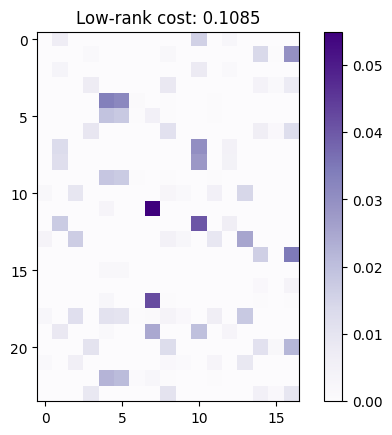

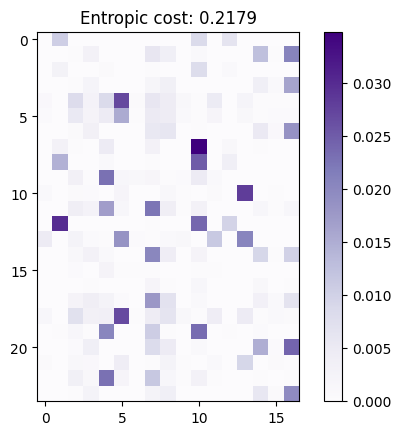

In [7]:
def plot_ot(ot, leg):
    plt.imshow(ot.matrix, cmap="Purples")
    plt.colorbar()
    plt.title(f"{leg} cost: {ot.primal_cost:.4f}")
    plt.show()


plot_ot(ot_gwlr, "Low-rank")
plot_ot(ot_gw, "Entropic")